In [114]:
import tushare as ts
import numpy as np 
import pandas as pd 
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from statsmodels import api as sm 


In [115]:
token = 'd9c35edffff16c8f0668cc226b492bcf8d4102be94328eca5b884ea0'
# 未经允许，以上token禁止商用
ts.set_token(token)
pro = ts.pro_api()

all_stocks = pro.stock_basic() # 获取所有上市公司

# 随机选择10支2018年1月1日上市前的股票
stocks = all_stocks.query('list_date < "20180101"').sample(10, random_state = 1) 

In [116]:
# 获取每支股票收盘价，并汇总在一起
close_df = pd.DataFrame()
for ts_code in stocks['ts_code']:
    df = ts.pro_bar(ts_code = ts_code, adj='qfq', start_date='20180101')
    df = df.set_index('trade_date') # 以交易日期作为表索引
    close_df[ts_code] = df['close']
    
close_df = close_df.sort_index() # 以交易日期排序
return_df = close_df.pct_change().dropna() # 计算每一天的涨跌幅

risk_free = 0.03  # 无风险利率

In [117]:
mean_return = return_df.mean().values # 各个标的平均日回报率 
cov_return = return_df.cov().values # 各个标的协方差矩阵
# Note: 以上两个变量都为全局变量

std_return = return_df.std().values # 各个标的回报标准差
sharpes =  (mean_return*252 - risk_free) / (std_return*np.sqrt(252)) # 各个标的夏普比率

# 转换为向量矩阵形式
n = len(mean_return)
I = np.ones(shape = (n,1))
R = np.mat(mean_return).T 
Rf = risk_free / 252 # 日无风险利率
cov = np.mat(cov_return) 
inv_cov = np.linalg.inv(cov)

A = float(R.T @ inv_cov @ R)
B = float(R.T @ inv_cov @ I)
C = float(I.T @ inv_cov @ I)

In [118]:
def get_return_of_portfolio(Ws):
    '''
    用途：获取组合的期望年回报率
    Ws：各个标的投资权重。一维数组形式
    mean_return：各资产标的平均日回报率
    '''
    return float(Ws @ mean_return * 252)

def get_variance_of_portfolio(Ws):
    '''
    用途：获取组合的方差
    Ws: 各个标的投资权重
    cov_mat: 各个标的协方差矩阵
    '''
    return float(Ws.T @ cov_return @ Ws * 252)

def get_optimize_weight(expect_return):
    '''
    用途：给定预期回报率,获取最小方差组合的配置权重
    expect_return：预期回报率
    '''
    Ws = (expect_return*C - B) / (A*C-B**2) * inv_cov @ R + (A-B*expect_return) / (A*C-B**2) * inv_cov @ I 
    return np.array(Ws)



# 有效前沿

In [119]:
# 在得到期望回报的前提下，最小化投资组合的方差
expect_returns = np.linspace(-1 ,2.5,100) / 252 # 预期组合回报率
variances = []
for expect_return in expect_returns:
    Ws = get_optimize_weight(expect_return)
    var = get_variance_of_portfolio(Ws)
    variances.append(var)
    
stds = np.array(variances)**0.5 # 年化标准差
 

# 最小方差组合

In [120]:
# 当期望回报 = B/C时，得到最小方差组合
minvar_expect_return = B / C 
Ws = get_optimize_weight(minvar_expect_return)
minvar = get_variance_of_portfolio(Ws)
minstd = minvar**0.5

# 资本市场线
* Capital Market Line 

给定预期回报率，使含无风险资产组合方差最小(夏普比率最大)

In [121]:
CML_expect_returns = np.linspace(risk_free ,2.5,100) / 252 # 预期组合回报率
variances = []
for expect_return in CML_expect_returns:
    # 计算最优配置权重
    Ws = (expect_return - Rf) /float((R - Rf * I).T @ inv_cov @ (R - Rf * I)) * inv_cov @ (R - Rf * I)
    Ws = np.array(Ws)
    var = get_variance_of_portfolio(Ws)
    variances.append(var)
    
CML_stds = np.array(variances)**0.5 # 年化标准差
 

# 可视化

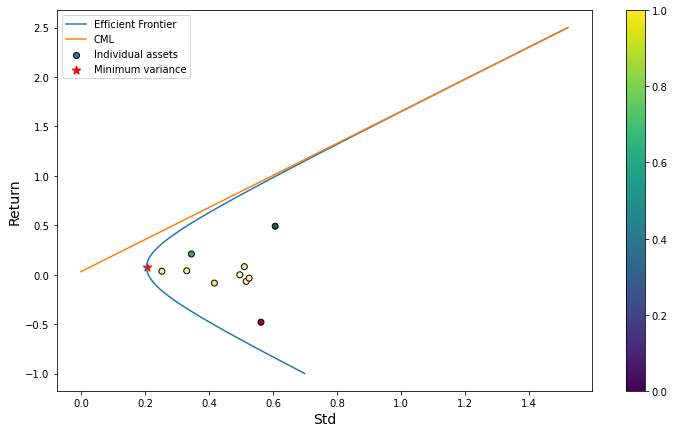

In [123]:
plt.figure(figsize = (12,7))
plt.plot(stds, expect_returns * 252, label = 'Efficient Frontier')

plt.plot(CML_stds, CML_expect_returns*252, label = 'CML' )

plt.scatter(std_return*np.sqrt(252), mean_return*252, c  = sharpes, 
             cmap='RdYlGn', edgecolors='black', label = 'Individual assets' )

plt.scatter(minstd, minvar_expect_return*252,  marker = '*', s = 80,
            color = 'red' ,label = 'Minimum variance')

plt.xlabel('Std', fontsize = 14)
plt.ylabel('Return', fontsize = 14)
plt.legend(loc = 'upper left')
plt.colorbar()
plt.show()